In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras


2.12.0


In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import src.relabel_data as rd

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# get the new data after filtering and relabeling
x_train, y_train, x_test, y_test = rd.filter_relabel(x_train, y_train, x_test, y_test)

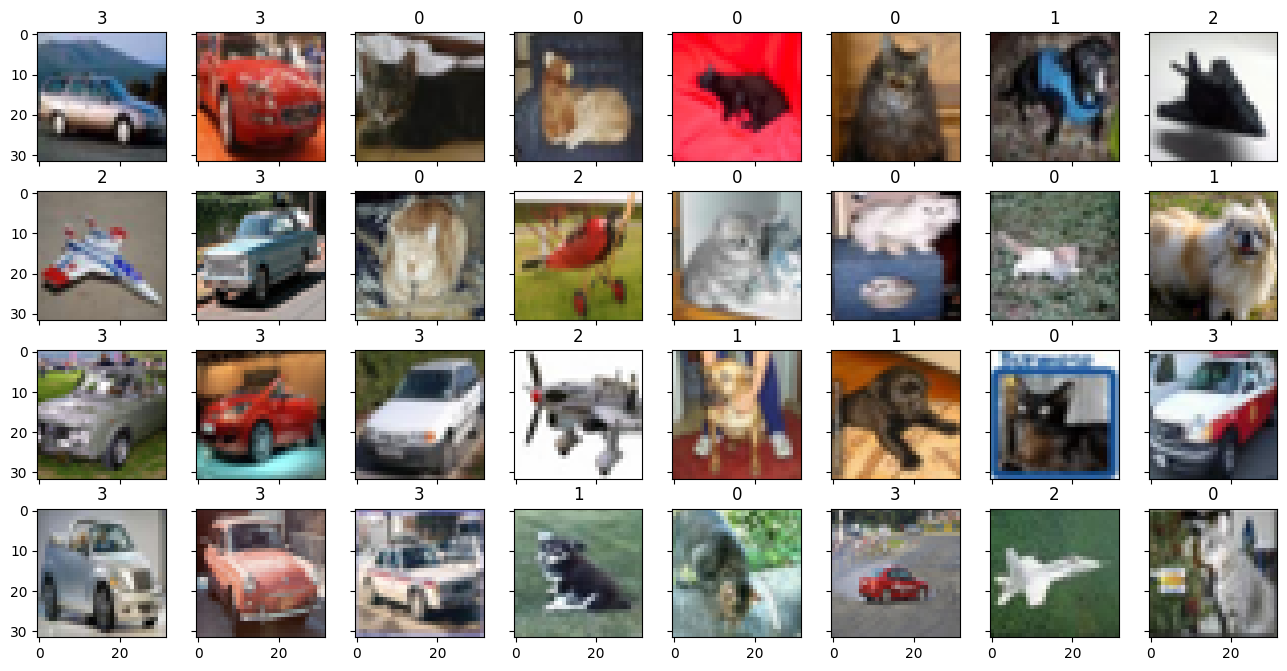

In [6]:
############## plot the images ##############

sample_images = x_train[:32]
sample_labels = y_train[:32]
fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()
